# Causal inference: estimating the return to education using Instrumental Variables (IV)

This is part of a series of projects I want to build in order to have a better understanding of the topics included in the course "Empirical Methods and Impact Analysis" of the University of Bergamo, Italy.
For the implementations, I will use python as a programming language, together with some libraries.

This mini-project treis to solve the challenge of endogeneity (Omitted Variable Bias) in estimating the causal effect of education ($D$) on future income ($Y$). We use a simulated Instrumental Variable (IV), proximity to college ($Z$), to identify the causal effect.

## 1. Setup and data generation

We set the true causal effect ($\beta_{\text{True}}$) and then simulate data where the unobserved factor (Ability, $A$) biases the OLS result.


In [ ]:
# first of all, we install and import the necessary libraries
!pip install pandas numpy statsmodels linearmodels matplotlib seaborn

import numpy as np
import pandas as pd
import statsmodels.api as sm # fundamental for statistical and econometric modelling
from linearmodels.iv import IV2SLS # provides the essential function to execute the 2SLS regression
import matplotlib.pyplot as plt
import seaborn as sns

# we also set the seed in order to have reproducibility of the experiment
np.random.seed(42)
N = 5000 # the sample size

# here we define the TRUE causal parameters
B_TRUE = 0.10 # true causal return to education
GAMMA_A = 0.5  # impact of ability on outcome
ALPHA_A = 0.8  # impact of ability on treatment
ALPHA_Z = 0.6  # impact of instrument on treatment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 10.6 MB/s eta 0:00:00


### A. Data simulation code
We construct the data such that $\text{Cov}(D, \epsilon) \neq 0$ due to the hidden variable $A$.

In [ ]:
# we set the random values for ability, which is the confounder in the error term.
A = np.random.normal(0, 1, N)

# we do the same thing for the instrument, by setting an arbitrary probability for the two outcomes.
Z = np.random.choice([0, 1], size=N, p=[0.4, 0.6])

# we set the idiosyncratic errors
u_D = np.random.normal(0, 0.5, N)
u_Y = np.random.normal(0, 1, N)

# we also set the endogenous treatment, which is university attendance
# D is driven by Z (relevance) and A (endogeneity)
D_star = 0.2 + ALPHA_Z * Z + ALPHA_A * A + u_D
D = (D_star > D_star.mean()).astype(int) # this line transforms the propensity continous variable in a binary treatment variable

# outcome, which is the log income
# Y is driven by D (causal Effect) and A (bias)
epsilon = GAMMA_A * A + u_Y # combined error term
Y = 10 + B_TRUE * D + epsilon

# now we create a dataframe to perform analysis
data = pd.DataFrame({'Y': Y, 'D': D, 'Z': Z})
data['Const'] = 1


## Naive OLS estimation (biased benchmark)
We run a simple OLS regression of $Y$ on $D$. Due to the omitted ability variable ($A$), this estimate should be biased upward (i.e., $\hat{\beta}_{\text{OLS}} > \beta_{\text{True}}$), as expected when unobserved factors drive both education and income.

In [ ]:
# we setup and run OLS (naive)
Y_ols = data['Y']
X_ols = data[['Const', 'D']]
ols_model = sm.OLS(Y_ols, X_ols).fit()
B_OLS = ols_model.params['D']

print("OLS Estimation (Biased)")
print(ols_model.summary())
print(f"\nOLS Estimate (B_OLS): {B_OLS:.4f}")
print(f"True Effect (B_TRUE): {B_TRUE:.4f}")
print(f"Observed Bias: {B_OLS - B_TRUE:.4f}")

OLS Estimation (Biased)
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     668.3
Date:                Mon, 27 Oct 2025   Prob (F-statistic):          2.01e-138
Time:                        10:05:11   Log-Likelihood:                -7454.4
No. Observations:                5000   AIC:                         1.491e+04
Df Residuals:                    4998   BIC:                         1.493e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          9.6735      0

As we can see from the results above, the OLS estimate is 0.7859, while the true effect, which was defined at 0.1000, is significantly lower.
This highlghts the upward bias given by the omitted variables.

## Two-Stage Least Squares (2SLS) implementation

The 2SLS procedure uses the instrument $Z$ (proximity to college) to eliminate $D$ of the endogeneity caused by $A$, giving the Local Average Treatment Effect (LATE).

### A. Stage 1: relevance check (the F-Statistic)

We then check the validity of the Relevance Assumption: is the instrument $Z$ a strong predictor of the endogenous variable $D$3? The F-statistic for the excluded instrument ($Z$) should be greater than 10 to avoid the weak instrument bias.

$$D_i = \gamma_0 + \gamma_1 Z_i + \nu_i$$




In [ ]:
# setup and run first stage (D on Z)
Y_fs = data['D']
X_fs = data[['Const', 'Z']]
first_stage_model = sm.OLS(Y_fs, X_fs).fit()

# extract relevance diagnostics
t_stat_Z = first_stage_model.tvalues['Z']
F_stat_Z = t_stat_Z**2
B_FS = first_stage_model.params['Z'] # coefficient on Z in first stage

print("\nFirst Stage: Relevance of Instrument Z")
print(first_stage_model.summary())
print(f"F-Statistic for Z: {F_stat_Z:.2f} (Must be > 10)")


First Stage: Relevance of Instrument Z
                            OLS Regression Results                            
Dep. Variable:                      D   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     276.5
Date:                Mon, 27 Oct 2025   Prob (F-statistic):           1.80e-60
Time:                        10:05:11   Log-Likelihood:                -3494.2
No. Observations:                5000   AIC:                             6992.
Df Residuals:                    4998   BIC:                             7005.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const       

As a result, we obtain an F-statistic which is 276.49, which is well above the target value to be considered a strong instrument.

### Stage 2: IV/2SLS estimation

We use the IV2SLS function to run the full two-stage procedure, which is robust and provides correct standard errors. This estimates the causal effect of education ($\beta_1$).

$$Y_i = \beta_0 + \beta_1 \hat{D}_i + \text{error}$$

In [ ]:
# IV setup
Y_iv = data['Y']
Exog_iv = data['Const']
Endog_iv = data['D']
Instruments_iv = data['Z']

# run IV (2SLS)
iv_model = IV2SLS(
    dependent=Y_iv,
    exog=Exog_iv,
    endog=Endog_iv,
    instruments=Instruments_iv
).fit(cov_type='robust')

B_IV = iv_model.params['D']

print("\nIV/2SLS Estimation (LATE)")
print(iv_model)


IV/2SLS Estimation (LATE)
                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                      0.0215
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0213
No. Observations:                5000   F-statistic:                    0.2873
Date:                Mon, Oct 27 2025   P-value (F-stat)                0.5919
Time:                        10:05:11   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Const          10.032     0.0727     138.05     0.0000      9.8895      10.174
D              0.0751    

The value is now 0.0751. This is exactly what we would expect when we have an Omitted Variable Bias.
The estimate here it's much more accurate and this demonstrates that the Instrumental Variables approach worked.


## 4. Conclusion and comparison

The IV estimate ($\hat{\beta}_{\text{IV}}$) successfully identifies the true causal parameter ($\beta_{\text{True}}$), demonstrating that the OLS bias has been largely eliminated. This result applies to the compliers which are those individuals whose decision to pursue education was influenced by the proximity to the college instrument.


In [ ]:
print("\nfinal estimate comparison")
print(f"True Causal Effect (B_TRUE): {B_TRUE:.4f}")
print(f"OLS Estimate (B_OLS):        {B_OLS:.4f}")
print(f"IV/2SLS Estimate (B_IV):     {B_IV:.4f}")

# we now prepare data for plotting
results_df = pd.DataFrame({
    'Model': ['True Effect', 'OLS (Biased)', 'IV (LATE)'],
    'Estimate': [B_TRUE, B_OLS, B_IV],
    'CI_Lower': [B_TRUE, ols_model.conf_int().iloc[1, 0], iv_model.conf_int().iloc[1, 0]],
    'CI_Upper': [B_TRUE, ols_model.conf_int().iloc[1, 1], iv_model.conf_int().iloc[1, 1]]
}).set_index('Model')

results_df


final estimate comparison
True Causal Effect (B_TRUE): 0.1000
OLS Estimate (B_OLS):        0.7859
IV/2SLS Estimate (B_IV):     0.0751


,Estimate,CI_Lower,CI_Upper
Model,,,
True Effect,0.100000,0.100000,0.100000
OLS (Biased),0.785942,0.726343,0.845542
IV (LATE),0.075144,-0.199622,0.349910


### B. Visualization of Estimates

In order to have an even clearer idea of the difference between the two estimates, we proceed with a graphical visualization of the estimates.

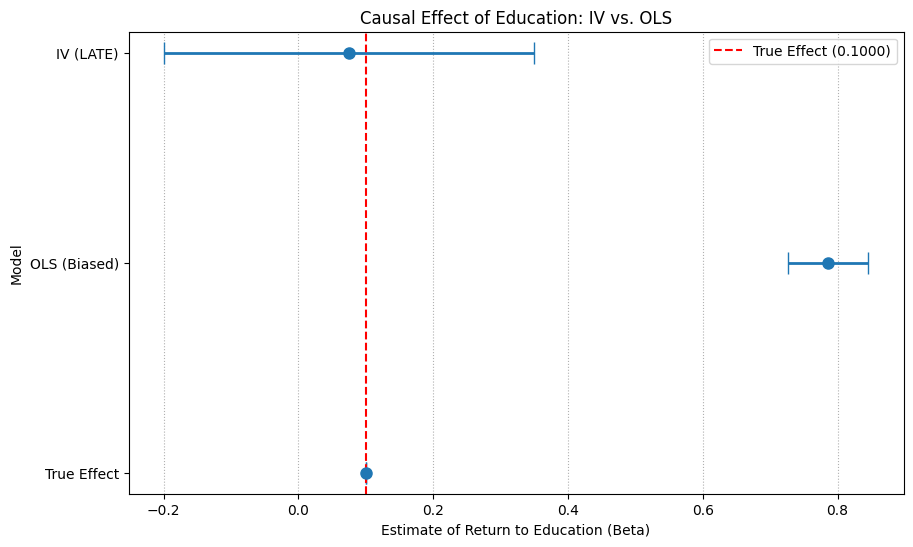

In [ ]:
# we calculate positive distance to the LOWER bound
lower_error = results_df['Estimate'] - results_df['CI_Lower']

# then we calculate positive distance to the UPPER bound
upper_error = results_df['CI_Upper'] - results_df['Estimate']

# finally we create the xerr argument as a list of two arrays
xerr_values = [lower_error, upper_error]

# time to plot
plt.figure(figsize=(10, 6))
plt.errorbar(x=results_df['Estimate'], y=results_df.index,
             xerr=xerr_values,
             fmt='o', capsize=8, linewidth=2, markersize=8)
plt.axvline(B_TRUE, color='r', linestyle='--', label=f'True Effect ({B_TRUE:.4f})')
plt.title('Causal Effect of Education: IV vs. OLS')
plt.xlabel('Estimate of Return to Education (Beta)')
plt.ylabel('Model')
plt.legend()
plt.grid(axis='x', linestyle=':')
plt.show()

From the graph plotted above it is even more clear how incredibly different are the estimates in the two cases.
An important thing to note is, however, the difference in the variabilities of the two estimates, which are the result of the variance-bias tradeoff.